<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/pytorch/1_7_ann_income_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Load Income Dataset

In [2]:
df = pd.read_csv('income.csv')
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [11]:
print(len(df))

30000


In [3]:
df['label'].value_counts()

label
0    21700
1     8300
Name: count, dtype: int64

In [4]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

### Shuffle Dataset

In [5]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')  # 5
print(f'cont_cols has {len(cont_cols)} columns') # 2
print(f'y_col     has {len(y_col)} column')      # 1

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


### Convert Category Columns to Category dtypes

In [6]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [9]:
df = shuffle(df, random_state=42)
df.reset_index(drop=True, inplace=True)
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,19,Female,Some-college,10,Never-married,Private,Sales,20,<=50K,0
1,34,Female,Some-college,10,Never-married,Private,Adm-clerical,40,<=50K,0
2,25,Male,Some-college,10,Never-married,State-gov,Tech-support,40,<=50K,0
3,18,Female,11th,7,Never-married,Private,Other-service,40,<=50K,0
4,28,Female,Bachelors,13,Never-married,Local-gov,Prof-specialty,40,<=50K,0


### Set Embedding sizes

In [13]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

### Create Categorical Array and Convert to tensor

In [14]:
sx = df['sex'].cat.codes.values
ed = df['education'].cat.codes.values
ms = df['marital-status'].cat.codes.values
wc = df['workclass'].cat.codes.values
oc = df['occupation'].cat.codes.values

cats = np.stack([sx,ed,ms,wc,oc], 1)

In [15]:
cats[:5]

array([[ 0, 13,  3,  2,  9],
       [ 0, 13,  3,  2,  0],
       [ 1, 13,  3,  4, 10],
       [ 0,  1,  3,  2,  6],
       [ 0,  8,  3,  1,  7]], dtype=int8)

In [16]:
cats = torch.tensor(cats, dtype=torch.int64)

### Create Continuous Array and Convert to tensor

In [17]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[19, 20],
       [34, 40],
       [25, 40],
       [18, 40],
       [28, 40]])

In [18]:
conts = torch.tensor(conts, dtype=torch.float)
conts.dtype

torch.float32

### Create a label tensor

In [19]:
y = torch.tensor(df[y_col].values).flatten()

## Create train and test data

In [20]:
b = 30000 # suggested batch size
t = 5000  # suggested test size

cat_train = cats[:b-t]
cat_test  = cats[b-t:b]
con_train = conts[:b-t]
con_test  = conts[b-t:b]
y_train   = y[:b-t]
y_test    = y[b-t:b]

## Define Model Class

In [21]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()

        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        # Assign a variable to hold a list of layers
        layerlist = []

        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)

        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)

        # Set up model layers
        x = self.layers(x)
        return x

In [23]:
## set random seed
torch.manual_seed(42)

In [24]:
model = TabularModel(emb_szs, conts.shape[1], 2, [50], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

### Define the loss and optimization functions

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

## Train Model

In [27]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)

    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.36035937
epoch:  26  loss: 0.35052344
epoch:  51  loss: 0.33785501
epoch:  76  loss: 0.32808501
epoch: 101  loss: 0.32391313
epoch: 126  loss: 0.31725010
epoch: 151  loss: 0.31038472
epoch: 176  loss: 0.30730870
epoch: 201  loss: 0.30604631
epoch: 226  loss: 0.30243450
epoch: 251  loss: 0.30148044
epoch: 276  loss: 0.29801252
epoch: 300  loss: 0.29833844

Duration: 22 seconds


### Plot Corss Entropy Loss

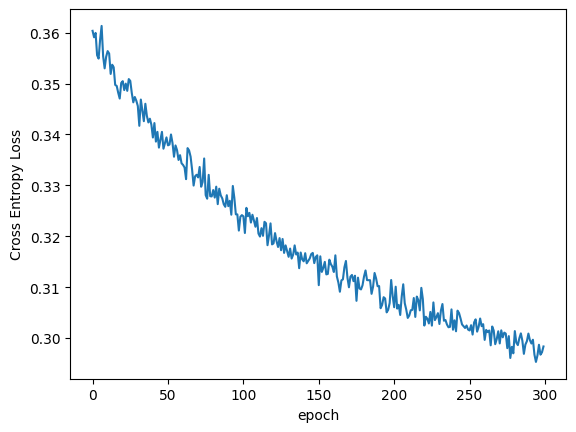

In [29]:
plt.plot(range(epochs), [loss.detach().numpy() for loss in losses]) # detach the tensors from the computation graph
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

## Evaluate Test Set

In [30]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.29214242


### Calculate Overall percent accuracy

In [31]:
rows = len(y_test)
correct = 0

# print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')

for i in range(rows):
    # print(f'{str(y_val[i]):26} {y_val[i].argmax().item():^7}{y_test[i]:^7}')

    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4353 out of 5000 = 87.06% correct
